## Попытки полуколец в контексте ресурсных сетей

In [1]:
from resource_networks import *
import matplotlib.pyplot as plt

from ipywidgets import interact, widgets

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True

plt.rcParams["font.size"] = 12

In [2]:
import plotly.graph_objs as go
import plotly.express as px

In [7]:
arr = np.random.randint(0, 10, 10).reshape((2, -1))
arr

array([[2, 5, 6, 7, 1],
       [5, 7, 8, 2, 5]])

In [18]:
class SimpleNodeArrayDescriptor:
    def __init__(self,
                 val_descriptor: dict[Hashable, int],
                 arr: np.ndarray | list[Any],
                 dims_affected: tuple[int] | None = None) -> None:
        self.val_descriptor = val_descriptor
        self.arr = arr
        self.dims_affected = set(dims_affected if dims_affected is not None else range(len(arr.shape)))
    def __getitem__(self, key):
        # [0, 2] => (arr['lala', 5, 1] => arr[desc['lala'], 5, desc[12]])
        key = (key,) if not isinstance(key, tuple) else key
        new_key = list(key)
        for i in range(len(key)):
            if i in self.dims_affected:
                new_key[i] = self.val_descriptor[key[i]]
        new_key = tuple(new_key)
        print(new_key)
        return self.arr[new_key if len(new_key) != 1 else new_key[0]]

In [19]:
arr_descr = SimpleNodeArrayDescriptor({'lala': 0, 'bebe': 1}, arr, (0,))
arr_descr['lala', 2]

(0, 2)


6

In [8]:
def plot_simulation(G, simulation):
    pl = G.plot_with_states(sim)
    f = lambda i: pl[i]
    interact(f, i=widgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0, description='№ of iteration')) 
    return None

In [9]:
G2 = ResourceDiGraph(nx.fast_gnp_random_graph(5, 0.4, directed=True))
sim = G2.run_simulation(np.random.randint(0, 10, size=5), 40)
plot_simulation(G2, sim)
# sim.arr

[14, 15, 5, 2, 0]


interactive(children=(IntSlider(value=0, description='№ of iteration', max=39), Output()), _dom_classes=('widg…

In [71]:
# for v in G2.G[1]:
#     print(v)
# plot_simulation(G2, sim)
sim.arr

array([[ 0.        ,  3.        ,  8.        ,  2.        ,  9.        ],
       [ 0.72727273,  7.90909091,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0.        ,  0.        , 13.36363636],
       [ 0.        ,  8.63636364,  0. 

---

In [213]:
G.edges['dsd', 1]

for u, v, d in G.edges(data=True):
    d['weight'] = 13
    
G['dsd'][1]

{'weight': 13, 'label': '43'}

In [200]:
G.graph.get("graph", {})

{'fontsize': 4}

In [212]:
# # print(nx.nx_pydot.to_pydot(G).create_dot().decode('utf-8'))
# G_pd = nx.nx_pydot.to_pydot(G)
# # G_pd.set('fontsize', 4)
# G_pd.get_attributes()
# print(G_pd.create_dot().decode('utf-8'))
# # G_pd.create_dot()

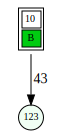

In [221]:
G = nx.DiGraph()
G.add_edge('dsd', 1, weight=2, label='43')

G.graph['node'] = {'fontsize': 10}
# G.graph['edge'] = {'fontsize': 10}
# G.graph['rankdir'] = 'LR'

# G.remove_edge(0, 1)
# first(G.edges(data=True))[2].get('weight')
# G.nodes['dsd']['penwidth'] = 4
# G.nodes['dsd']['label'] = """<
# <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
#   <TR><TD ROWSPAN="3" BGCOLOR="yellow">class</TD></TR>
#   <TR><TD PORT="here" BGCOLOR="lightblue">qualifier</TD></TR>
# </TABLE>>"""
G.nodes['dsd']['shape'] = 'plaintext'
G.nodes['dsd']['label'] = f"""<<table>
                          <tr><td>{10}</td></tr>
                          <tr><td bgcolor='#00CC11'>B</td></tr>
                       </table>>
"""

G.nodes[1]['tooltip'] = 'lalalala'

G.nodes[1]['shape'] = 'circle'
G.nodes[1]['style'] = 'filled'
G.nodes[1]['fillcolor'] = '#f0fff4'
G.nodes[1]['fixedsize'] = True
# G.nodes[1]['fontsize'] = 10
G.nodes[1]['width'] = 0.35
G.nodes[1]['label'] = 123

# print(nx.nx_pydot.to_pydot(G).create_dot().decode('utf-8'))
SVG(nx.nx_pydot.to_pydot(G).create_svg())

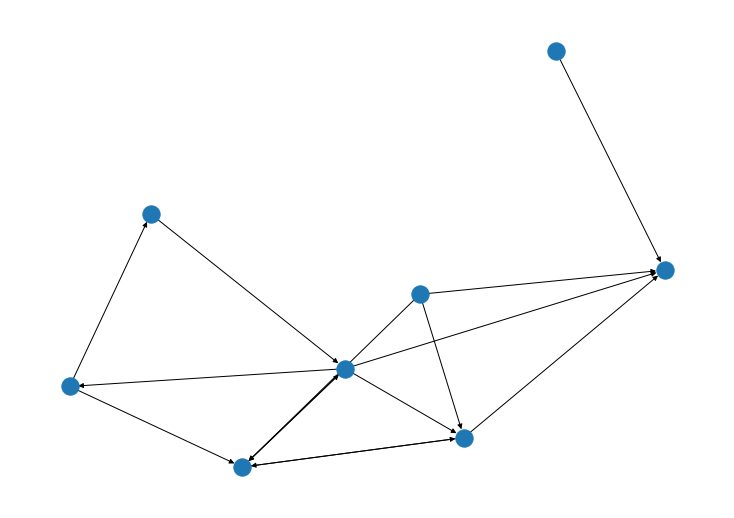

In [63]:
nx.draw(nx.fast_gnp_random_graph(8,0.2, directed=True))

In [12]:
class dummy:
    def __getitem__(self, key):
        return key

In [16]:
dummy()[1:10, 3]

(slice(1, 10, None), 3)

In [17]:
tuple((1,2))

(1, 2)

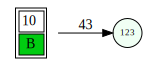

In [44]:
G_ = nx.nx_pydot.to_pydot(G)
G_.set('rankdir', 'LR')
SVG(G_.create_svg())

In [ ]:
B = np.array([[0, 2],
              [2, 0]])
# np.linalg.matrix_power(B, 2)
# np.apply_over_axes(lambda x: x**2, B, [])
B[0] = [2, 3]
B

In [43]:
play = widgets.Play(
    value=50,
    min=0,
    max=100,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])

---